# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([ 0.02252628, -0.22546313, -0.04558341,  0.27605851]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.5960414218044785 -2.791166820195571


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [14]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # returning the given data to the model
    return actions, states

In [15]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [16]:
def model_loss(actions, states, # model input
               action_size, hidden_size): # model init for Qs
        
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits[:-1], 
                                                                     labels=actions_onehot[1:]))
    # last_action = tf.zeros([1, action_size])
    # actions_labels = tf.concat(axis=0, values=[actions_onehot[1:], last_action])
    # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
    #                                                                  labels=actions_labels))
    # # # #if actions.shape[0] < 200: 
    # def loss_false(): 
    #     return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
    #                                                                      labels=actions_labels))
    # # # #if actions.shape[0] = 200: 
    # def loss_true(): 
    #     return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits[:-1], 
    #                                                                      labels=actions_onehot[1:]))
    # loss = tf.cond(pred=tf.equal(total_rewards, 200), 
    #                true_fn=loss_true, 
    #                false_fn=loss_false)
        
    return actions_logits, loss

In [17]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions) # model input
        
        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [19]:
# from collections import deque

# class Memory():    
#     def __init__(self, max_size = 1000):
#         self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [20]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [21]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [22]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [23]:
env.reset()

array([ 0.01803979,  0.03887065, -0.04092467, -0.04432966])

In [24]:
# # Initialize the simulation
# state = env.reset()
# batch = []

# # Make a bunch of random actions and store the experiences
# for each_step in range(max_steps):
    
#     # Take one random step to get the pole and cart moving
#     action = env.action_space.sample()
#     state, _, done, _ = env.step(action)
#     reward = 1 - float(done)
#     #memory.buffer.append((action, state, reward))
#     batch.append((action, state, reward))
    
#     # End of the episodes which defines the goal of the episode/mission
#     if done is True:
#         # Start new episode
#         #env.reset()
#         break

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
state, reward, action

(array([-0.17587433, -1.39474964,  0.14486672,  2.02858008]), 1.0, 0)

In [34]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        state = env.reset() # env first state
        batch = [] # every data batch

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Get action from model
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            action *= reward
            batch.append([action, state])
            if done is True:
                break
                
        #batch = memory.buffer
        actions = np.array([each[0] for each in batch])
        states = np.array([each[1] for each in batch])
        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                 model.states: states})
            
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(len(batch)),
              'Batch loss: {:.9f}'.format(loss),
              'Episode done: {}'.format(done))
        print('-------------------------------------------------------------------------------')
        rewards_list.append((ep, len(batch)))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 10 Batch loss: 0.602121711 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 8 Batch loss: 0.610163033 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 9 Batch loss: 0.582945943 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 9 Batch loss: 0.564852715 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 41 Total reward: 10 Batch loss: 0.335227340 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 42 Total reward: 8 Batch loss: 0.380454928 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 43 Total reward: 9 Batch loss: 0.345836222 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 44 Total reward: 9 Batch loss: 0.339358181 Episode done: True
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 82 Total reward: 10 Batch loss: 0.133845702 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 83 Total reward: 10 Batch loss: 0.134000719 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 84 Total reward: 9 Batch loss: 0.145676270 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 85 Total reward: 10 Batch loss: 0.132423431 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 126 Total reward: 20 Batch loss: 0.203338623 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 127 Total reward: 17 Batch loss: 0.229755998 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 128 Total reward: 17 Batch loss: 0.221738786 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 129 Total reward: 21 Batch loss: 0.226548046 Episode done: True
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 162 Total reward: 29 Batch loss: 0.193959862 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 29 Batch loss: 0.164575741 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 28 Batch loss: 0.115529478 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 165 Total reward: 24 Batch loss: 0.113457061 Episode done: True
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 201 Total reward: 22 Batch loss: 0.095301613 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 26 Batch loss: 0.078080654 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 203 Total reward: 27 Batch loss: 0.217905194 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 204 Total reward: 26 Batch loss: 0.076679289 Episode done: True
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 238 Total reward: 30 Batch loss: 0.053711586 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 239 Total reward: 36 Batch loss: 0.102059357 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 240 Total reward: 39 Batch loss: 0.080601655 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 241 Total reward: 28 Batch loss: 0.085454673 Episode done: True
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 276 Total reward: 31 Batch loss: 0.051108513 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 277 Total reward: 39 Batch loss: 0.048948672 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 32 Batch loss: 0.116592184 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 31 Batch loss: 0.073398612 Episode done: True
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 312 Total reward: 59 Batch loss: 0.076423310 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 313 Total reward: 48 Batch loss: 0.058910441 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 314 Total reward: 61 Batch loss: 0.082555167 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 315 Total reward: 58 Batch loss: 0.061589707 Episode done: True
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 350 Total reward: 83 Batch loss: 0.047402229 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 351 Total reward: 70 Batch loss: 0.112806365 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 352 Total reward: 80 Batch loss: 0.072706476 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 353 Total reward: 59 Batch loss: 0.040720783 Episode done: True
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 386 Total reward: 200 Batch loss: 0.186816379 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 387 Total reward: 121 Batch loss: 0.040625080 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 388 Total reward: 117 Batch loss: 0.047435157 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 389 Total reward: 200 Batch loss: 0.258483529 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 422 Total reward: 163 Batch loss: 0.035422880 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 423 Total reward: 200 Batch loss: 0.065297619 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 424 Total reward: 192 Batch loss: 0.030971006 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 425 Total reward: 200 Batch loss: 0.246568859 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 459 Total reward: 200 Batch loss: 0.322408080 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 460 Total reward: 200 Batch loss: 0.053788882 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 461 Total reward: 200 Batch loss: 0.258780092 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 462 Total reward: 200 Batch loss: 0.322432786 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 495 Total reward: 200 Batch loss: 0.020968271 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 496 Total reward: 200 Batch loss: 0.179742783 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 497 Total reward: 200 Batch loss: 0.247792616 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 498 Total reward: 111 Batch loss: 0.080288410 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 531 Total reward: 200 Batch loss: 0.207120791 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 532 Total reward: 200 Batch loss: 0.237679616 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 129 Batch loss: 0.049527362 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 200 Batch loss: 0.172057241 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 567 Total reward: 200 Batch loss: 0.026764117 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 568 Total reward: 200 Batch loss: 0.022175087 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 569 Total reward: 200 Batch loss: 0.229828641 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 570 Total reward: 200 Batch loss: 0.359354764 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 604 Total reward: 200 Batch loss: 0.297708780 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 605 Total reward: 200 Batch loss: 0.332926005 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 606 Total reward: 200 Batch loss: 0.319691747 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 607 Total reward: 200 Batch loss: 0.202162743 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 640 Total reward: 200 Batch loss: 0.143233910 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 641 Total reward: 200 Batch loss: 0.182652473 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 642 Total reward: 200 Batch loss: 0.240998134 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 643 Total reward: 200 Batch loss: 0.157592326 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 677 Total reward: 200 Batch loss: 0.211247429 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 678 Total reward: 200 Batch loss: 0.249386460 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 679 Total reward: 200 Batch loss: 0.106888510 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 680 Total reward: 88 Batch loss: 0.084890656 Episode done: True
-------------------------------------------------------------------------------
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 713 Total reward: 105 Batch loss: 0.164629430 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 714 Total reward: 200 Batch loss: 0.041684970 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 715 Total reward: 200 Batch loss: 0.277022958 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 716 Total reward: 200 Batch loss: 0.299587786 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 749 Total reward: 200 Batch loss: 0.272675663 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 750 Total reward: 74 Batch loss: 0.037672292 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 751 Total reward: 200 Batch loss: 0.288125038 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 752 Total reward: 77 Batch loss: 0.192053154 Episode done: True
-------------------------------------------------------------------------------
------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 785 Total reward: 200 Batch loss: 0.336398035 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 786 Total reward: 200 Batch loss: 0.252103746 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 787 Total reward: 200 Batch loss: 0.174906150 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 788 Total reward: 200 Batch loss: 0.272563577 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 821 Total reward: 200 Batch loss: 0.272163182 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 822 Total reward: 200 Batch loss: 0.326514930 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 823 Total reward: 56 Batch loss: 0.276702285 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 824 Total reward: 161 Batch loss: 0.066978335 Episode done: True
-------------------------------------------------------------------------------
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 858 Total reward: 200 Batch loss: 0.307789505 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 859 Total reward: 200 Batch loss: 0.088300236 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 860 Total reward: 200 Batch loss: 0.064657234 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 861 Total reward: 200 Batch loss: 0.180211648 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 894 Total reward: 200 Batch loss: 0.283924550 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 895 Total reward: 200 Batch loss: 0.243301570 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 896 Total reward: 200 Batch loss: 0.258800596 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 897 Total reward: 200 Batch loss: 0.226848736 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 930 Total reward: 200 Batch loss: 0.243409321 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 931 Total reward: 200 Batch loss: 0.212272227 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 932 Total reward: 200 Batch loss: 0.292931616 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 933 Total reward: 200 Batch loss: 0.216042757 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 966 Total reward: 200 Batch loss: 0.213497013 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 967 Total reward: 200 Batch loss: 0.306649029 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 968 Total reward: 200 Batch loss: 0.260314524 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 969 Total reward: 200 Batch loss: 0.263445288 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

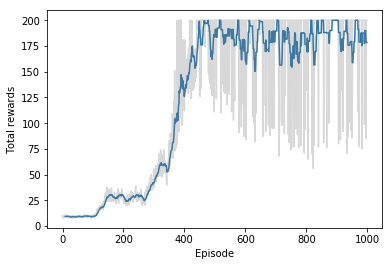

In [39]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

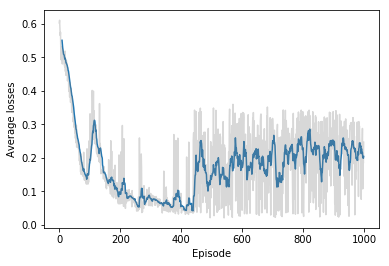

In [40]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [42]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for each_episode in range(1):

        # Start a new episode/epoch
        state = env.reset()
        
        # Rendering the env graphics
        env.render()

        # Steps/batches
        for each_step in range(111111111111111111):
                        
            # Calculating next action using OLD memory
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            #reward = 1 - float(done)
            if done:
                break
                
# Closing the env
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.